In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from m3util.viz.style import set_style
from m3util.viz.layout import layout_fig
from dl_utils.utils.utils import list_to_dict, sort_tasks_by_size, viz_h5_structure, find_symm_index_in_hdf5, fetch_img_metadata
from dl_utils.utils.viz import verify_image_vector
from dl_utils.utils.dataset import viz_dataloader, split_train_valid, hdf5_dataset
from dl_utils.training.build_model import resnet50_, fpn_resnet50_classification, xcit_small
from dl_utils.analysis.case_analysis import prediction_vs_actual, most_confused_pairs, generate_prediction_example
from dl_utils.analysis.confusion_matrix import plot_cm, show_multiple_cm
from dl_utils.analysis.attention_map import AttentionMapVisualizer
from dl_utils.analysis.evaluate_symmetry import crop_image_with_mask, find_valid_starting_points, calculate_shift_tolerant_ssim, find_all_regions, rot_4f_eval, rot_2f_eval, mirror_eval
from dl_utils.packed_functions import viz_4confusion_matrix, generate_attention_maps
set_style("printing")

symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']

/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


printing set for seaborn


## design symmetry operation evaluation

In [2]:
ds_path = f'../../../Wallpaper_Group_Symmetry_Dataset/datasets/imagenet_v5/imagenet_v5_rot_10k_fix_vector_a100_0.h5'
with h5py.File(ds_path) as h5:
    viz_h5_structure(h5)

'Group': imagenet
  'Dataset': data; Shape: (10013, 256, 256, 3); dtype: uint8
  'Dataset': labels; Shape: (10013,); dtype: uint8
  'Dataset': primitive_uc_vector_a; Shape: (10013, 2); dtype: int32
  'Dataset': primitive_uc_vector_b; Shape: (10013, 2); dtype: int32
  'Dataset': rotation_angle; Shape: (10013,); dtype: uint8
  'Dataset': shape; Shape: (10013,); dtype: uint8
  'Dataset': translation_start_point; Shape: (10013, 2); dtype: int32
  'Dataset': translation_uc_vector_a; Shape: (10013, 2); dtype: int32
  'Dataset': translation_uc_vector_b; Shape: (10013, 2); dtype: int32


### crop patterns

In [5]:
device = torch.device('cpu')
model = resnet50_(in_channels=3, n_classes=17)
model.load_state_dict(torch.load('../../models/ResNet50/09112024-resnet50-dataset_v5_size-10m/model_epoch_20.pth', weights_only=True, map_location=device))
model.eval()
layers = ['layer4', 'layer3', 'layer2', 'layer1']
model_type = 'ResNet50'

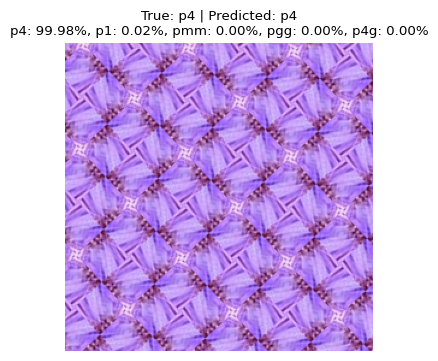

/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.11/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


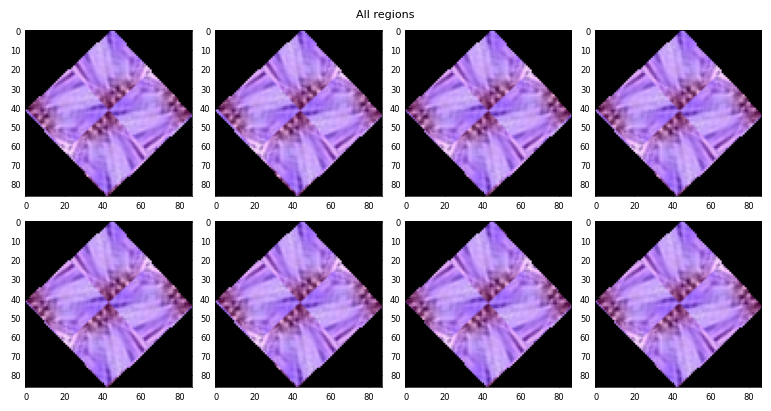

In [ ]:
viz = True

## crop regions and test
ds_path = f'../../../Wallpaper_Group_Symmetry_Dataset/datasets/imagenet_v5/imagenet_v5_rot_10k_fix_vector_a100_0.h5'
group = 'imagenet'
confusion_pair = ('p4', 'p4')
img, label, top_predictions, probs, metadata = generate_prediction_example(model, '../../datasets/imagenet_v5_rot_10k_fix_vector_a100_0.h5', t=confusion_pair[0], p=confusion_pair[1], classes=symmetry_classes, device=device, group='imagenet', viz=viz)
ts, va, vb, VA, VB = metadata['ts'], metadata['va'], metadata['vb'], metadata['VA'], metadata['VB']
regions, masks, valid_ts_list = find_all_regions(img, ts, VA, VB, viz=viz)
print(len(regions), regions[0].shape, len(masks), len(valid_ts_list))

### rot 2f, 4f

In [ ]:
result = {}
result['rot_4f'] = np.mean(rot_4f_eval(regions, viz=viz))
result['rot_2f'] = np.mean(rot_2f_eval(regions, viz=viz))
result

{'rot_4f': 0.5349696752201597, 'rot_2f': 0.6203842532627968}

### 

### other symmetries operation: glide

image shape is (256, 256, 3), class: p4, translation start point: [107  81], va: [20 23], vb: [ 23 -20], VA: [41 46], VB: [ 46 -41]


/mnt/scratch/home/yichen/anaconda3/envs/symmetry/lib/python3.12/site-packages/m3util/viz/layout.py:255: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=wspace, hspace=hspace)


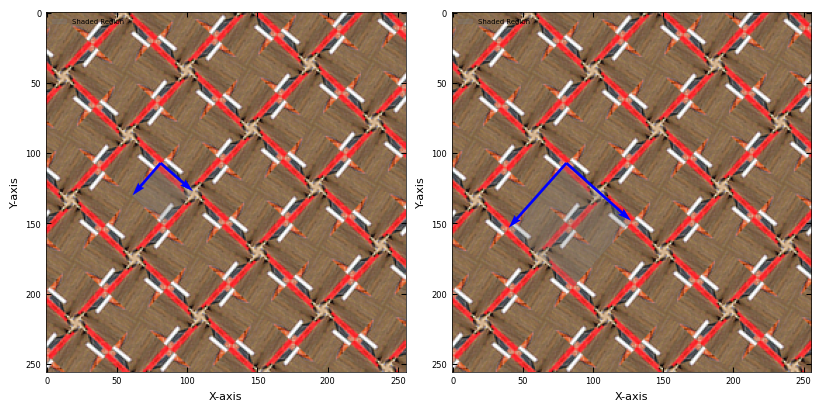

In [23]:
ds_path = f'../../../Wallpaper_Group_Symmetry_Dataset/datasets/imagenet_v5/imagenet_v5_rot_10k_fix_vector_a100_0.h5'
group = 'imagenet'
with h5py.File(ds_path) as h5:
    index = find_symm_index_in_hdf5(h5, symm_str='p4', group=group, index_start=1000, index_end=None)
    
    img, label, ts = h5[group]['data'][index], h5[group]['labels'][index], h5[group]['translation_start_point'][index]
    va, vb = h5[group]['primitive_uc_vector_a'][index], h5[group]['primitive_uc_vector_b'][index]
    VA, VB = h5[group]['translation_uc_vector_a'][index], h5[group]['translation_uc_vector_b'][index]
    
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

print(f"image shape is {img.shape}, class: {label_converter[label]}, translation start point: {ts}, va: {va}, vb: {vb}, VA: {VA}, VB: {VB}")

fig, axes = layout_fig(2, 2, figsize=(10, 4))
verify_image_vector(ax=axes[0], image=img, ts=ts, va=va, vb=vb)
verify_image_vector(ax=axes[1], image=img, ts=ts, va=VA, vb=VB)
plt.show()

In [ ]:
regions, masks, valid_ts_list = find_all_regions(img, ts, VA, VB)

fig, axes = layout_fig(len(valid_ts_list), 4, figsize=(8, 2*(len(valid_ts_list)//5+1)))
for ax, ts in zip(axes, valid_ts_list):
    verify_image_vector(ax=ax, image=img, ts=ts, va=VA, vb=VB, shade_alpha=0.3, shade_color='white')
plt.show()
   
fig, axes = layout_fig(len(valid_ts_list), 4, figsize=(8, 2*(len(valid_ts_list)//5+1)))
for ax, ts, cropped_img in zip(axes, valid_ts_list, regions):
    ax.imshow(cropped_img)
plt.show()

In [ ]:
viz = False
result = {}
for attention_map, overlay_attention_map, layer in zip(attention_map_resized_list, overlay_attention_map_list, layers):
    print(f"Layer: {layer}")
    result[layer] = {}
    regions, masks, valid_ts_list = find_all_regions(attention_map, ts-vb, VA, VB, viz=viz)
    result[layer]['rot_4f'] = np.mean(rot_4f_eval(regions, viz=viz))
    
    regions, masks, valid_ts_list = find_all_regions(attention_map, ts, VA, VB, viz=viz)
    result[layer]['rot_2f'] = np.mean(rot_2f_eval(regions, viz=viz))
    # result[layer]['mirror'] = np.mean(mirror_eval(regions, viz=viz))
result